In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
import sys
sys.path.insert(0,'/content/gdrive/My Drive/Colab Notebooks')

Mounted at /content/gdrive/


In [ ]:
from project_utilities import Loss
from project_utilities import efficiency
from project_utilities import ValueSet

In [ ]:
from helper_funcs import MyDataset
from helper_funcs import get_random_indices, plot_values, plot_num_excitations, plot_non_zero_hist, plot_correlation
from helper_funcs import get_train_test_split_indices, get_params, train, validate
from helper_funcs import plot_training_graphs, plot_results


## DEVICE

In [ ]:
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:0


In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
import os
print(os.environ["CUBLAS_WORKSPACE_CONFIG"])

:4096:8


In [ ]:
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True)
set_deterministic()

## Change Directory

In [ ]:
%cd /content/gdrive/My Drive/dl_mid3/data

/content/gdrive/My Drive/dl_mid3/data


## Training and Test sets

In [ ]:
# Large training sample
train_set_idx_l, val_set_idx_l = get_train_test_split_indices(20)

Training set len: 59 
Training set indices: [56, 28, 50, 38, 49, 79, 12, 8, 31, 65, 59, 27, 48, 33, 74, 30, 1, 37, 2, 6, 46, 64, 26, 60, 7, 76, 40, 45, 62, 70, 61, 21, 72, 4, 18, 24, 19, 3, 51, 11, 9, 41, 29, 71, 52, 58, 25, 54, 14, 77, 55, 57, 10, 32, 36, 63, 66, 53, 78]
Validation set len: 20 
Validation set indices: [22, 34, 73, 20, 16, 44, 17, 13, 75, 35, 23, 39, 47, 15, 42, 67, 69, 43, 68, 5]


In [ ]:
# Medium training sample
train_set_idx_m, val_set_idx_m = get_train_test_split_indices(40)

Training set len: 39 
Training set indices: [33, 23, 70, 60, 42, 69, 56, 25, 6, 47, 76, 48, 20, 34, 14, 52, 64, 53, 32, 31, 8, 79, 37, 58, 74, 15, 51, 2, 27, 63, 35, 3, 46, 29, 61, 68, 77, 67, 7]
Validation set len: 40 
Validation set indices: [45, 22, 62, 36, 11, 1, 78, 75, 30, 71, 18, 39, 26, 9, 73, 65, 44, 17, 5, 41, 13, 10, 4, 28, 38, 59, 49, 40, 16, 50, 12, 21, 24, 54, 57, 55, 66, 43, 72, 19]


In [ ]:
# Small training sample
train_set_idx_s, val_set_idx_s = get_train_test_split_indices(60)

Training set len: 19 
Training set indices: [15, 75, 27, 49, 3, 10, 21, 13, 53, 42, 79, 62, 36, 16, 40, 4, 61, 29, 37]
Validation set len: 60 
Validation set indices: [9, 2, 51, 46, 18, 6, 35, 45, 59, 63, 70, 30, 24, 50, 66, 25, 28, 56, 14, 69, 1, 52, 12, 78, 48, 17, 54, 31, 23, 8, 55, 5, 64, 32, 33, 72, 67, 71, 26, 58, 77, 11, 57, 38, 44, 22, 39, 34, 73, 65, 76, 7, 68, 19, 74, 60, 41, 43, 47, 20]


In [ ]:
# One training sample
train_set_idx_o, val_set_idx_o = get_train_test_split_indices(78)

Training set len: 1 
Training set indices: [50]
Validation set len: 78 
Validation set indices: [55, 51, 49, 1, 74, 62, 14, 13, 25, 63, 32, 60, 58, 23, 53, 41, 4, 9, 79, 27, 66, 72, 26, 29, 5, 2, 8, 28, 7, 52, 30, 67, 19, 38, 10, 44, 21, 33, 24, 54, 71, 61, 36, 75, 42, 35, 45, 16, 20, 37, 70, 73, 69, 40, 76, 56, 68, 31, 48, 47, 43, 6, 77, 18, 11, 78, 64, 15, 17, 22, 46, 39, 34, 65, 3, 59, 57, 12]


In [ ]:
## Very small validation set to use while training for overfir or underfit
train_set_idx_sv, val_set_idx_sv = get_train_test_split_indices(5)

Training set len: 74 
Training set indices: [53, 34, 21, 57, 24, 10, 51, 71, 28, 70, 32, 25, 55, 4, 33, 62, 17, 54, 35, 43, 76, 31, 8, 78, 14, 58, 1, 75, 7, 13, 47, 41, 52, 56, 74, 12, 37, 65, 27, 45, 26, 29, 64, 44, 15, 6, 20, 67, 18, 23, 49, 36, 72, 42, 22, 11, 46, 50, 5, 61, 63, 60, 40, 16, 9, 19, 68, 3, 2, 38, 79, 39, 77, 30]
Validation set len: 5 
Validation set indices: [73, 48, 66, 59, 69]


In [ ]:
## Debugging dataset with small train and val
train_set_idx_db, val_set_idx_db = get_train_test_split_indices(5, 11)

Training set len: 5 
Training set indices: [3, 7, 8, 9, 5]
Validation set len: 5 
Validation set indices: [2, 1, 6, 4, 10]


## Architectures

## Simple RNN

In [ ]:
class SimpleRNN1(torch.nn.Module):
  def __init__(self, num_input_features, num_output_features):
    super(SimpleRNN1, self).__init__()
    self.flatten = torch.nn.Flatten()
    self.linear = torch.nn.Linear(num_input_features, num_output_features)
    self.rnn1 =  torch.nn.LSTM(num_output_features, 128)
    self.fc = torch.nn.Linear(128,  num_output_features)

  def forward(self, x):
    flat_x = self.linear(self.flatten(x))
    output, (hidden, cell) = self.rnn1(flat_x)

    fc_output = self.fc(output)

    return fc_output

In [ ]:
loss_model = Loss(0.00001)
model = SimpleRNN1(4*4000, 4000)
model.to(DEVICE)

SimpleRNN1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=16000, out_features=4000, bias=True)
  (rnn1): LSTM(4000, 128)
  (fc): Linear(in_features=128, out_features=4000, bias=True)
)

In [ ]:
print(get_params(model))

66634560


In [ ]:
NUM_EPOCHS = 1

In [ ]:
(cost_l,
 efficiency_train_l,
 efficiency_val_l,
 fp_rate_train_l,
 fp_rate_val_l) = train(model,
                        DEVICE=DEVICE,
                        loss_model=loss_model,
                        num_epochs=NUM_EPOCHS,
                        train_set_idx=train_set_idx_db,
                        val_set_idx=val_set_idx_db[:1],
                        learning_rate=0.001,
                        seed=123,
                        batch_size=500)

Start Time -  30/11/2022 21:01:13
Set index: 1, Set Id: 10
Epoch ID: 0   Set ID: 10  Batch ID: 1 | Loss: 7.41897
Epoch ID: 0   Set ID: 10  Batch ID: 2 | Loss: 7.42264
Epoch ID: 0   Set ID: 10  Batch ID: 3 | Loss: 7.41595
Epoch ID: 0   Set ID: 10  Batch ID: 4 | Loss: 7.41844


## This model automatically started crashing as it was too heavy

In [ ]:
loss_val, eff_rate, fp_rate = validate(model, DEVICE, loss_model, val_set_idx_l)
print('Loss: %0.3f ' % loss_val, end="")
print('  Efficiency: %0.3f' % eff_rate, end="")
print('  False positive rate: %0.3f' % fp_rate)

In [ ]:
plot_training_graphs(
    NUM_EPOCHS,
    cost_l,
    efficiency_train_l,
    efficiency_val_l,
    fp_rate_train_l,
    fp_rate_val_l)

In [ ]:
plot_results(model,DEVICE, 6)

## RNN2 with a simple embedding layer

In [ ]:
class SimpleRNN2(torch.nn.Module):
  def __init__(self, num_input_features, embedding_dim, hidden_dim, num_output_features):
    super(SimpleRNN2, self).__init__()
    self.enco1 = torch.nn.Linear(num_input_features, embedding_dim)
    # self.enco2 = torch.nn.Linear(8000, embedding_dim)
    self.rnn = torch.nn.LSTM(embedding_dim, hidden_dim)
    # self.deco1 = torch.nn.Linear(hidden_dim, 8000)
    self.deco2 = torch.nn.Linear(hidden_dim, num_output_features)

  def forward(self, x):
        # print("x", x.shape)
        # print("x", x.view(-1, 16000).shape)
        x = self.enco1(x.view(-1, 16000))
        # print("x", x.shape)
        x = torch.nn.functional.relu(x)
        # print("x", x.shape)
        # x = self.enco2(x)
        # print("x", x.shape)
        # x = torch.nn.functional.relu(x)
        # print("x", x.shape)
        output, (hidden, cell) = self.rnn(x)

        # output = self.deco1(output)
        output = self.deco2(output)
        # print("output", output.shape)
        return output

In [ ]:
EMBEDDING_DIM = 1024
HIDDEN_DIM = 256

In [ ]:
loss_model = Loss(0.00001)
model = SimpleRNN2(num_input_features=16000,
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            num_output_features=4000 )
model.to(DEVICE)

SimpleRNN2(
  (enco1): Linear(in_features=16000, out_features=1024, bias=True)
  (rnn): LSTM(1024, 256)
  (deco2): Linear(in_features=256, out_features=4000, bias=True)
)

In [ ]:
print(get_params(model))

18725792


In [ ]:
NUM_EPOCHS = 1

In [ ]:
(cost_l,
 efficiency_train_l,
 efficiency_val_l,
 fp_rate_train_l,
 fp_rate_val_l) = train(model,
                        DEVICE=DEVICE,
                        loss_model=loss_model,
                        num_epochs=NUM_EPOCHS,
                        train_set_idx=train_set_idx_db,
                        val_set_idx=val_set_idx_db[:1],
                        learning_rate=0.001,
                        seed=123,
                        batch_size=500)

Start Time -  30/11/2022 21:05:53
Set index: 1, Set Id: 5
Epoch ID: 0   Set ID: 5  Batch ID: 1 | Loss: 6.99750
Epoch ID: 0   Set ID: 5  Batch ID: 2 | Loss: 6.99592
Epoch ID: 0   Set ID: 5  Batch ID: 3 | Loss: 6.99799
Epoch ID: 0   Set ID: 5  Batch ID: 4 | Loss: 6.99862
Epoch ID: 0   Set ID: 5  Batch ID: 5 | Loss: 6.99642
Epoch ID: 0   Set ID: 5  Batch ID: 6 | Loss: 6.99794
Epoch ID: 0   Set ID: 5  Batch ID: 7 | Loss: 6.99849
Epoch ID: 0   Set ID: 5  Batch ID: 8 | Loss: 7.00222
Epoch ID: 0   Set ID: 5  Batch ID: 9 | Loss: 6.99978
Epoch ID: 0   Set ID: 5  Batch ID: 10 | Loss: 6.99956
Set Time : 0.04858498175938924 minutes
Time till now : 0.048585096995035805 minutes
Set index: 2, Set Id: 1
Epoch ID: 0   Set ID: 1  Batch ID: 11 | Loss: 6.99964
Epoch ID: 0   Set ID: 1  Batch ID: 12 | Loss: 6.99562
Epoch ID: 0   Set ID: 1  Batch ID: 13 | Loss: 6.99740
Epoch ID: 0   Set ID: 1  Batch ID: 14 | Loss: 6.99679
Epoch ID: 0   Set ID: 1  Batch ID: 15 | Loss: 6.99363
Epoch ID: 0   Set ID: 1  Batch ID

In [ ]:
loss_val, eff_rate, fp_rate = validate(model, DEVICE, loss_model, val_set_idx_db)
print('Loss: %0.3f ' % loss_val, end="")
print('  Efficiency: %0.3f' % eff_rate, end="")
print('  False positive rate: %0.3f' % fp_rate)

Validating 
2
6
3
10
7
Loss: 7.079   Efficiency: 0.105  False positive rate: 39.249


1 50 50 1 50 1


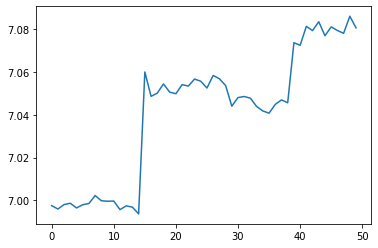

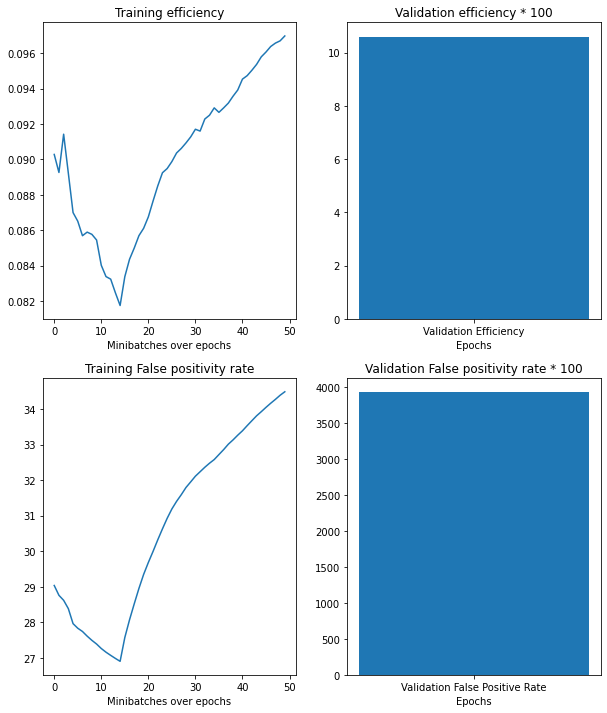

In [ ]:
plot_training_graphs(
    NUM_EPOCHS,
    cost_l,
    efficiency_train_l,
    efficiency_val_l,
    fp_rate_train_l,
    fp_rate_val_l)

Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000


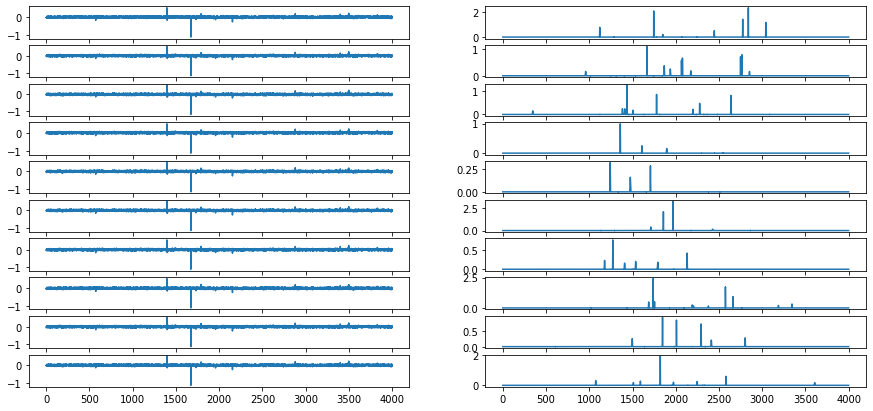

In [ ]:
plot_results(model,DEVICE, 6)

## Increasing the embeding dimensions

In [ ]:
EMBEDDING_DIM = 2048
HIDDEN_DIM = 512

loss_model = Loss(0.00001)
model = SimpleRNN2(num_input_features=16000,
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            num_output_features=4000)
model.to(DEVICE)

SimpleRNN2(
  (enco1): Linear(in_features=16000, out_features=2048, bias=True)
  (rnn): LSTM(2048, 512)
  (deco2): Linear(in_features=512, out_features=4000, bias=True)
)

In [ ]:
print(get_params(model))

40069024


In [ ]:
NUM_EPOCHS = 1

In [ ]:
(cost_l,
 efficiency_train_l,
 efficiency_val_l,
 fp_rate_train_l,
 fp_rate_val_l) = train(model,
                        DEVICE=DEVICE,
                        loss_model=loss_model,
                        num_epochs=NUM_EPOCHS,
                        train_set_idx=train_set_idx_db,
                        val_set_idx=val_set_idx_db[:1],
                        learning_rate=0.001,
                        seed=123,
                        batch_size=500)

Start Time -  30/11/2022 21:15:46
Set index: 1, Set Id: 5
Epoch ID: 0   Set ID: 5  Batch ID: 1 | Loss: 6.67649
Epoch ID: 0   Set ID: 5  Batch ID: 2 | Loss: 6.70087
Epoch ID: 0   Set ID: 5  Batch ID: 3 | Loss: 6.70111
Epoch ID: 0   Set ID: 5  Batch ID: 4 | Loss: 6.70179
Epoch ID: 0   Set ID: 5  Batch ID: 5 | Loss: 6.69822
Epoch ID: 0   Set ID: 5  Batch ID: 6 | Loss: 6.69831
Epoch ID: 0   Set ID: 5  Batch ID: 7 | Loss: 6.70055
Epoch ID: 0   Set ID: 5  Batch ID: 8 | Loss: 6.70145
Epoch ID: 0   Set ID: 5  Batch ID: 9 | Loss: 6.72103
Epoch ID: 0   Set ID: 5  Batch ID: 10 | Loss: 6.71941
Set Time : 0.0474750558535258 minutes
Time till now : 0.04747520287831624 minutes
Set index: 2, Set Id: 1
Epoch ID: 0   Set ID: 1  Batch ID: 11 | Loss: 6.74801
Epoch ID: 0   Set ID: 1  Batch ID: 12 | Loss: 6.74452
Epoch ID: 0   Set ID: 1  Batch ID: 13 | Loss: 6.74405
Epoch ID: 0   Set ID: 1  Batch ID: 14 | Loss: 6.74722
Epoch ID: 0   Set ID: 1  Batch ID: 15 | Loss: 6.74531
Epoch ID: 0   Set ID: 1  Batch ID: 

In [ ]:
loss_val, eff_rate, fp_rate = validate(model, DEVICE, loss_model, val_set_idx_db)
print('Loss: %0.3f ' % loss_val, end="")
print('  Efficiency: %0.3f' % eff_rate, end="")
print('  False positive rate: %0.3f' % fp_rate)

Validating 
2
6
3
10
7
Loss: 6.766   Efficiency: 0.028  False positive rate: 10.160


1 50 50 1 50 1


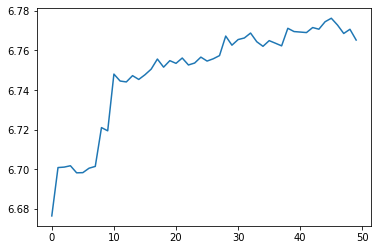

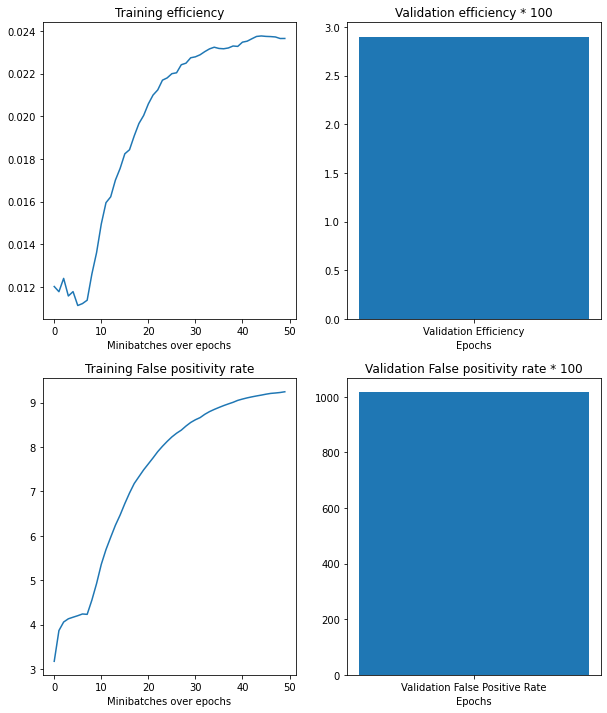

In [ ]:
plot_training_graphs(
    NUM_EPOCHS,
    cost_l,
    efficiency_train_l,
    efficiency_val_l,
    fp_rate_train_l,
    fp_rate_val_l)

Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000


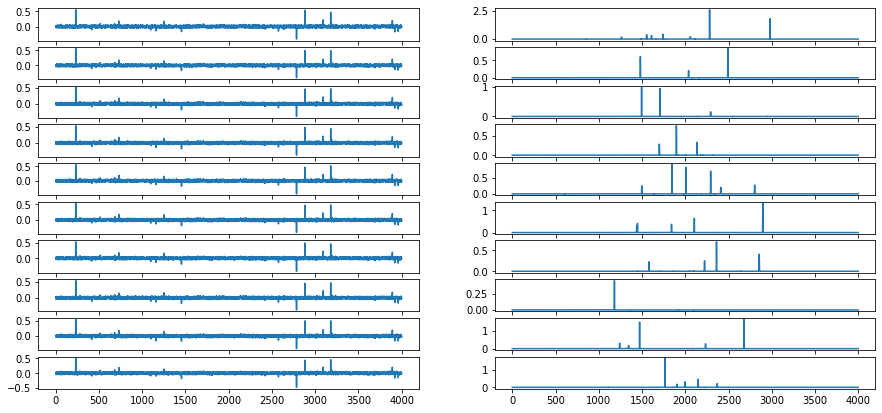

In [ ]:
plot_results(model,DEVICE, 6)

## Reducing learning rate

In [ ]:
EMBEDDING_DIM = 2048
HIDDEN_DIM = 512

loss_model = Loss(0.00001)
model = SimpleRNN2(num_input_features=16000,
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            num_output_features=4000)
model.to(DEVICE)

SimpleRNN2(
  (enco1): Linear(in_features=16000, out_features=2048, bias=True)
  (rnn): LSTM(2048, 512)
  (deco2): Linear(in_features=512, out_features=4000, bias=True)
)

In [ ]:
print(get_params(model))

40069024


In [ ]:
NUM_EPOCHS = 1

In [ ]:
(cost_l,
 efficiency_train_l,
 efficiency_val_l,
 fp_rate_train_l,
 fp_rate_val_l) = train(model,
                        DEVICE=DEVICE,
                        loss_model=loss_model,
                        num_epochs=NUM_EPOCHS,
                        train_set_idx=train_set_idx_db,
                        val_set_idx=val_set_idx_db[:1],
                        learning_rate=1e-5,
                        seed=123,
                        batch_size=500)

Start Time -  30/11/2022 21:18:20
Set index: 1, Set Id: 5
Epoch ID: 0   Set ID: 5  Batch ID: 1 | Loss: 6.68020
Epoch ID: 0   Set ID: 5  Batch ID: 2 | Loss: 6.68026
Epoch ID: 0   Set ID: 5  Batch ID: 3 | Loss: 6.68195
Epoch ID: 0   Set ID: 5  Batch ID: 4 | Loss: 6.68283
Epoch ID: 0   Set ID: 5  Batch ID: 5 | Loss: 6.67980
Epoch ID: 0   Set ID: 5  Batch ID: 6 | Loss: 6.68046
Epoch ID: 0   Set ID: 5  Batch ID: 7 | Loss: 6.67884
Epoch ID: 0   Set ID: 5  Batch ID: 8 | Loss: 6.68021
Epoch ID: 0   Set ID: 5  Batch ID: 9 | Loss: 6.67990
Epoch ID: 0   Set ID: 5  Batch ID: 10 | Loss: 6.67828
Set Time : 0.04841094811757406 minutes
Time till now : 0.048411087195078535 minutes
Set index: 2, Set Id: 1
Epoch ID: 0   Set ID: 1  Batch ID: 11 | Loss: 6.68127
Epoch ID: 0   Set ID: 1  Batch ID: 12 | Loss: 6.67923
Epoch ID: 0   Set ID: 1  Batch ID: 13 | Loss: 6.68093
Epoch ID: 0   Set ID: 1  Batch ID: 14 | Loss: 6.68188
Epoch ID: 0   Set ID: 1  Batch ID: 15 | Loss: 6.67934
Epoch ID: 0   Set ID: 1  Batch ID

In [ ]:
loss_val, eff_rate, fp_rate = validate(model, DEVICE, loss_model, val_set_idx_db)
print('Loss: %0.3f ' % loss_val, end="")
print('  Efficiency: %0.3f' % eff_rate, end="")
print('  False positive rate: %0.3f' % fp_rate)

Validating 
2
6
3
10
7
Loss: 6.681   Efficiency: 0.004  False positive rate: 3.377


1 50 50 1 50 1


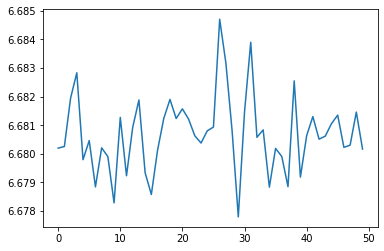

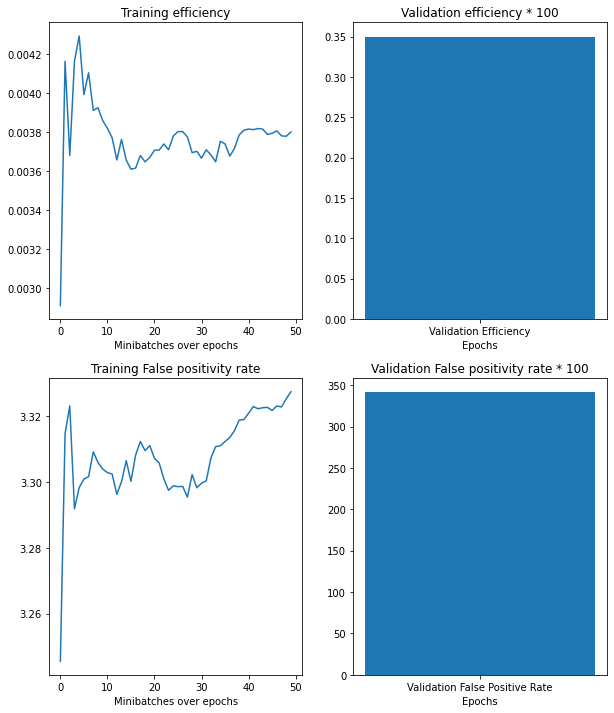

In [ ]:
plot_training_graphs(
    NUM_EPOCHS,
    cost_l,
    efficiency_train_l,
    efficiency_val_l,
    fp_rate_train_l,
    fp_rate_val_l)

Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000


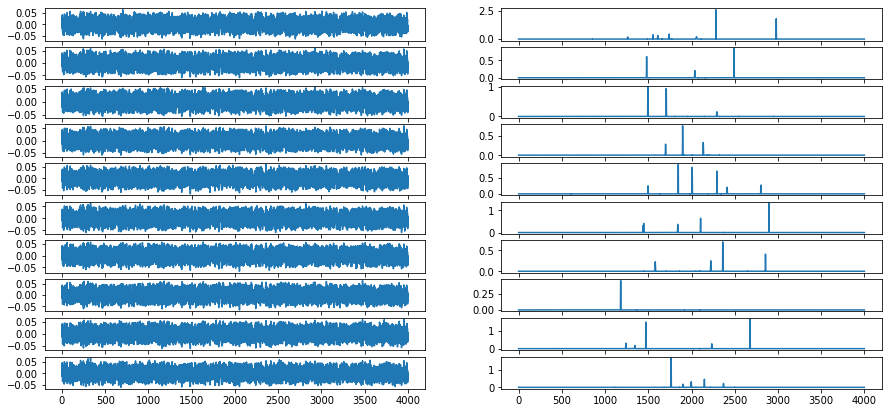

In [ ]:
plot_results(model,DEVICE, 6)

## Falling back on lr and Increasing epochs

In [ ]:
EMBEDDING_DIM = 1024
HIDDEN_DIM = 256

loss_model = Loss(0.00001)
model = SimpleRNN2(num_input_features=16000,
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            num_output_features=4000)
model.to(DEVICE)

SimpleRNN2(
  (enco1): Linear(in_features=16000, out_features=1024, bias=True)
  (rnn): LSTM(1024, 256)
  (deco2): Linear(in_features=256, out_features=4000, bias=True)
)

In [ ]:
print(get_params(model))

18725792


In [ ]:
NUM_EPOCHS = 5

In [ ]:
(cost_l,
 efficiency_train_l,
 efficiency_val_l,
 fp_rate_train_l,
 fp_rate_val_l) = train(model,
                        DEVICE=DEVICE,
                        loss_model=loss_model,
                        num_epochs=NUM_EPOCHS,
                        train_set_idx=train_set_idx_db,
                        val_set_idx=val_set_idx_db[:1],
                        learning_rate=0.001,
                        seed=123,
                        batch_size=250)

Start Time -  30/11/2022 21:31:39
Set index: 1, Set Id: 10
Epoch ID: 0   Set ID: 10  Batch ID: 1 | Loss: 7.01663
Epoch ID: 0   Set ID: 10  Batch ID: 2 | Loss: 7.01829
Epoch ID: 0   Set ID: 10  Batch ID: 3 | Loss: 7.02132
Epoch ID: 0   Set ID: 10  Batch ID: 4 | Loss: 7.02239
Epoch ID: 0   Set ID: 10  Batch ID: 5 | Loss: 7.01735
Epoch ID: 0   Set ID: 10  Batch ID: 6 | Loss: 7.02110
Epoch ID: 0   Set ID: 10  Batch ID: 7 | Loss: 7.02360
Epoch ID: 0   Set ID: 10  Batch ID: 8 | Loss: 7.02312
Epoch ID: 0   Set ID: 10  Batch ID: 9 | Loss: 7.02438
Epoch ID: 0   Set ID: 10  Batch ID: 10 | Loss: 7.02243
Epoch ID: 0   Set ID: 10  Batch ID: 11 | Loss: 7.01613
Epoch ID: 0   Set ID: 10  Batch ID: 12 | Loss: 7.02151
Epoch ID: 0   Set ID: 10  Batch ID: 13 | Loss: 7.01926
Epoch ID: 0   Set ID: 10  Batch ID: 14 | Loss: 7.01925
Epoch ID: 0   Set ID: 10  Batch ID: 15 | Loss: 7.02417
Epoch ID: 0   Set ID: 10  Batch ID: 16 | Loss: 7.01986
Epoch ID: 0   Set ID: 10  Batch ID: 17 | Loss: 7.02218
Epoch ID: 0   S

In [ ]:
loss_val, eff_rate, fp_rate = validate(model, DEVICE, loss_model, val_set_idx_db)
print('Loss: %0.3f ' % loss_val, end="")
print('  Efficiency: %0.3f' % eff_rate, end="")
print('  False positive rate: %0.3f' % fp_rate)

In [ ]:
plot_training_graphs(
    NUM_EPOCHS,
    cost_l,
    efficiency_train_l,
    efficiency_val_l,
    fp_rate_train_l,
    fp_rate_val_l)

In [ ]:
plot_results(model,DEVICE, 6)

## The above model was crashing so changing the architecture a little

## Updating architecture by adding more layers

In [ ]:
class SimpleRNN4(torch.nn.Module):
  def __init__(self, num_input_features, embedding_dim, hidden_dim1, hidden_dim2, num_output_features):
    super(SimpleRNN4, self).__init__()
    self.enco1 = torch.nn.Linear(num_input_features, embedding_dim)
    # self.enco2 = torch.nn.Linear(8000, embedding_dim)
    self.rnn = torch.nn.LSTM(embedding_dim, hidden_dim1)
    # self.deco1 = torch.nn.Linear(hidden_dim, 8000)
    self.deco1 = torch.nn.Linear(hidden_dim1, hidden_dim2)
    self.deco2 = torch.nn.Linear(hidden_dim2, num_output_features)

  def forward(self, x):
        # print("x", x.shape)
        # print("x", x.view(-1, 16000).shape)
        x = self.enco1(x.view(-1, 16000))
        # print("x", x.shape)
        x = torch.nn.functional.relu(x)
        # print("x", x.shape)
        # x = self.enco2(x)
        # print("x", x.shape)
        # x = torch.nn.functional.relu(x)
        # print("x", x.shape)
        output, (hidden, cell) = self.rnn(x)

        output = self.deco1(output)
        output = self.deco2(output)
        # print("output", output.shape)
        return output

In [ ]:
EMBEDDING_DIM = 512
HIDDEN_DIM = 128

loss_model = Loss(0.00001)
model = SimpleRNN4(num_input_features=16000,
            embedding_dim=EMBEDDING_DIM,
            hidden_dim1=HIDDEN_DIM,
            hidden_dim2=512,
            num_output_features=4000)
model.to(DEVICE)

SimpleRNN4(
  (enco1): Linear(in_features=16000, out_features=512, bias=True)
  (rnn): LSTM(512, 128)
  (deco1): Linear(in_features=128, out_features=512, bias=True)
  (deco2): Linear(in_features=512, out_features=4000, bias=True)
)

In [ ]:
print(get_params(model))

10639264


In [ ]:
NUM_EPOCHS = 3

In [ ]:
(cost_l,
 efficiency_train_l,
 efficiency_val_l,
 fp_rate_train_l,
 fp_rate_val_l) = train(model,
                        DEVICE=DEVICE,
                        loss_model=loss_model,
                        num_epochs=NUM_EPOCHS,
                        train_set_idx=train_set_idx_db,
                        val_set_idx=val_set_idx_db[:1],
                        learning_rate=0.001,
                        seed=123,
                        batch_size=500)

Start Time -  30/11/2022 21:38:20
Set index: 1, Set Id: 5
Epoch ID: 0   Set ID: 5  Batch ID: 1 | Loss: 7.19023
Epoch ID: 0   Set ID: 5  Batch ID: 2 | Loss: 7.19096
Epoch ID: 0   Set ID: 5  Batch ID: 3 | Loss: 7.19260
Epoch ID: 0   Set ID: 5  Batch ID: 4 | Loss: 7.19449
Epoch ID: 0   Set ID: 5  Batch ID: 5 | Loss: 7.22853
Epoch ID: 0   Set ID: 5  Batch ID: 6 | Loss: 7.22616
Epoch ID: 0   Set ID: 5  Batch ID: 7 | Loss: 7.22820
Epoch ID: 0   Set ID: 5  Batch ID: 8 | Loss: 7.22960
Epoch ID: 0   Set ID: 5  Batch ID: 9 | Loss: 7.22538
Epoch ID: 0   Set ID: 5  Batch ID: 10 | Loss: 7.22379
Set Time : 0.04233774741490682 minutes
Time till now : 0.04233876864115397 minutes
Set index: 2, Set Id: 4
Epoch ID: 0   Set ID: 4  Batch ID: 11 | Loss: 7.22378
Epoch ID: 0   Set ID: 4  Batch ID: 12 | Loss: 7.22213
Epoch ID: 0   Set ID: 4  Batch ID: 13 | Loss: 7.22192
Epoch ID: 0   Set ID: 4  Batch ID: 14 | Loss: 7.21964
Epoch ID: 0   Set ID: 4  Batch ID: 15 | Loss: 7.23847
Epoch ID: 0   Set ID: 4  Batch ID:

In [ ]:
loss_val, eff_rate, fp_rate = validate(model, DEVICE, loss_model, val_set_idx_l)
print('Loss: %0.3f ' % loss_val, end="")
print('  Efficiency: %0.3f' % eff_rate, end="")
print('  False positive rate: %0.3f' % fp_rate)

Validating 
63
78
2
79
31
68
51
26
69
49
13
54
46
70
29
66
47
44
23
32
Loss: 7.543   Efficiency: 0.315  False positive rate: 133.017


3 150 150 3 150 3


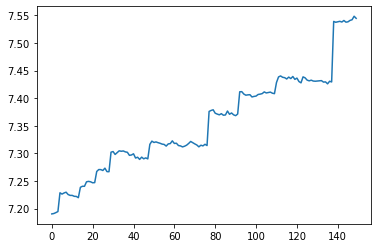

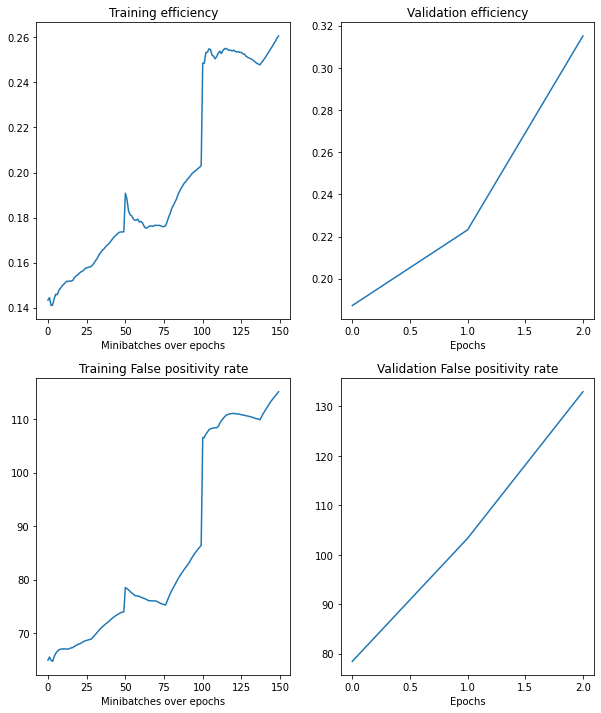

In [ ]:
plot_training_graphs(
    NUM_EPOCHS,
    cost_l,
    efficiency_train_l,
    efficiency_val_l,
    fp_rate_train_l,
    fp_rate_val_l)

Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000


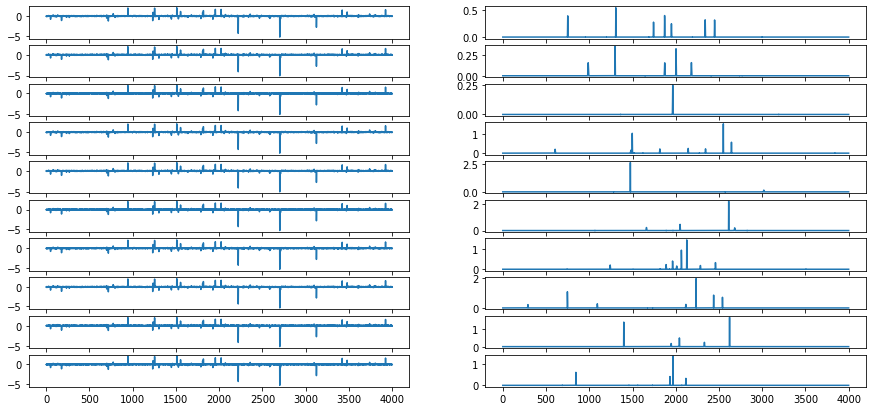

In [ ]:
plot_results(model,DEVICE, 6)

## Small large dataset

## Reducing the dims as well because it is crashing

In [ ]:
EMBEDDING_DIM = 512
HIDDEN_DIM = 128

loss_model = Loss(0.00001)
model_s = SimpleRNN4(num_input_features=16000,
            embedding_dim=128,
            hidden_dim1=64,
            hidden_dim2=128,
            num_output_features=4000)
model_s.to(DEVICE)

SimpleRNN4(
  (enco1): Linear(in_features=16000, out_features=128, bias=True)
  (rnn): LSTM(128, 64)
  (deco1): Linear(in_features=64, out_features=128, bias=True)
  (deco2): Linear(in_features=128, out_features=4000, bias=True)
)

In [ ]:
print(get_params(model_s))

2622112


## Session is crashing for anything more than 1 epoch so falling back to 1 epoch only and anyway we aren't seeing any improvement with more epochs.

In [ ]:
NUM_EPOCHS = 1

In [ ]:
(cost_s,
 efficiency_train_s,
 efficiency_val_s,
 fp_rate_train_s,
 fp_rate_val_s) = train(model_s,
                        DEVICE=DEVICE,
                        loss_model=loss_model,
                        num_epochs=NUM_EPOCHS,
                        train_set_idx=train_set_idx_s,
                        val_set_idx=val_set_idx_db[:1],
                        learning_rate=0.001,
                        seed=123,
                        batch_size=1000)

Start Time -  01/12/2022 14:34:04
Set index: 1, Set Id: 15
Epoch ID: 0   Set ID: 15  Batch ID: 1 | Loss: 7.48771
Epoch ID: 0   Set ID: 15  Batch ID: 2 | Loss: 7.48303
Epoch ID: 0   Set ID: 15  Batch ID: 3 | Loss: 7.48012
Epoch ID: 0   Set ID: 15  Batch ID: 4 | Loss: 7.48790
Epoch ID: 0   Set ID: 15  Batch ID: 5 | Loss: 7.48693
Set Time : 0.045254011948903404 minutes
Time till now : 0.04525519609451294 minutes
Set index: 2, Set Id: 75
Epoch ID: 0   Set ID: 75  Batch ID: 6 | Loss: 7.48533
Epoch ID: 0   Set ID: 75  Batch ID: 7 | Loss: 7.48988
Epoch ID: 0   Set ID: 75  Batch ID: 8 | Loss: 7.48488
Epoch ID: 0   Set ID: 75  Batch ID: 9 | Loss: 7.48504
Epoch ID: 0   Set ID: 75  Batch ID: 10 | Loss: 7.48467
Set Time : 0.04084610939025879 minutes
Time till now : 0.0861244797706604 minutes
Set index: 3, Set Id: 27
Epoch ID: 0   Set ID: 27  Batch ID: 11 | Loss: 7.50303
Epoch ID: 0   Set ID: 27  Batch ID: 12 | Loss: 7.49783
Epoch ID: 0   Set ID: 27  Batch ID: 13 | Loss: 7.49678
Epoch ID: 0   Set I

In [ ]:
loss_val, eff_rate, fp_rate = validate(model_s, DEVICE, loss_model, val_set_idx_l)
print('Loss: %0.3f ' % loss_val, end="")
print('  Efficiency: %0.3f' % eff_rate, end="")
print('  False positive rate: %0.3f' % fp_rate)

Validating 
22
34
73
20
16
44
17
13
75
35
23
39
47
15
42
67
69
43
68
5
Loss: 7.594   Efficiency: 0.266  False positive rate: 121.573


1 95 95 1 95 1


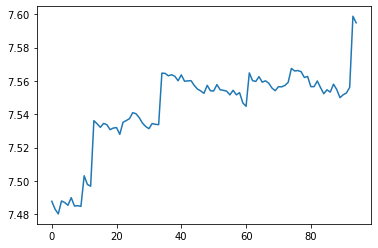

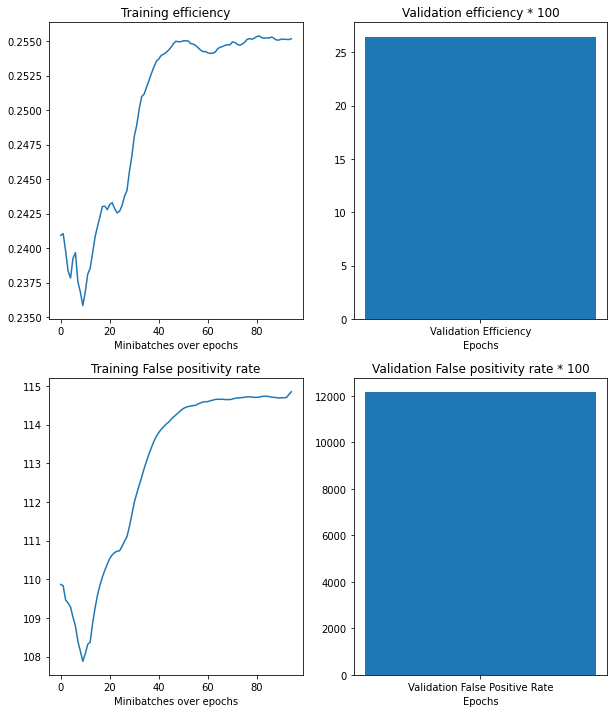

In [ ]:
plot_training_graphs(
    NUM_EPOCHS,
    cost_s,
    efficiency_train_s,
    efficiency_val_s,
    fp_rate_train_s,
    fp_rate_val_s)

Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000


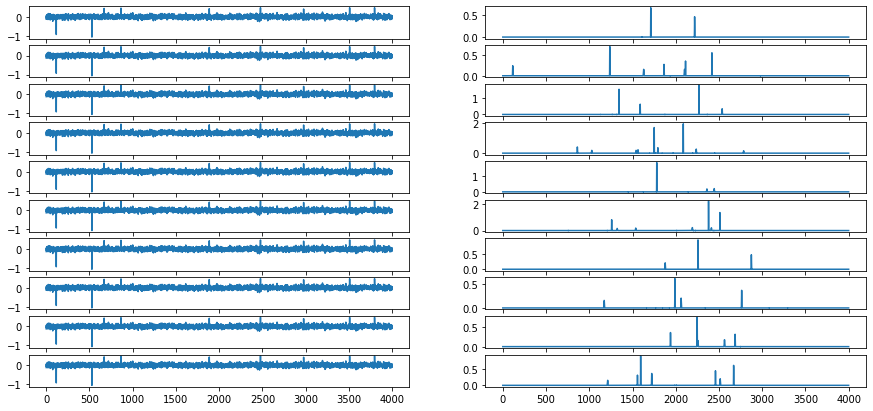

In [ ]:
plot_results(model_s,DEVICE, 6)

## Medium dataset

In [ ]:
EMBEDDING_DIM = 512
HIDDEN_DIM = 128

loss_model = Loss(0.00001)
model_m = SimpleRNN4(num_input_features=16000,
            embedding_dim=EMBEDDING_DIM,
            hidden_dim1=HIDDEN_DIM,
            hidden_dim2=512,
            num_output_features=4000)
model_m.to(DEVICE)

SimpleRNN4(
  (enco1): Linear(in_features=16000, out_features=512, bias=True)
  (rnn): LSTM(512, 128)
  (deco1): Linear(in_features=128, out_features=512, bias=True)
  (deco2): Linear(in_features=512, out_features=4000, bias=True)
)

In [ ]:
print(get_params(model_m))

10639264


In [ ]:
NUM_EPOCHS = 2

In [ ]:
(cost_m,
 efficiency_train_m,
 efficiency_val_m,
 fp_rate_train_m,
 fp_rate_val_m) = train(model_m,
                        DEVICE=DEVICE,
                        loss_model=loss_model,
                        num_epochs=NUM_EPOCHS,
                        train_set_idx=train_set_idx_m,
                        val_set_idx=val_set_idx_db[:1],
                        learning_rate=0.001,
                        seed=123,
                        batch_size=1000)

Start Time -  01/12/2022 14:37:21
Set index: 1, Set Id: 33
Epoch ID: 0   Set ID: 33  Batch ID: 1 | Loss: 6.95433
Epoch ID: 0   Set ID: 33  Batch ID: 2 | Loss: 6.95696
Epoch ID: 0   Set ID: 33  Batch ID: 3 | Loss: 6.95400
Epoch ID: 0   Set ID: 33  Batch ID: 4 | Loss: 6.95499
Epoch ID: 0   Set ID: 33  Batch ID: 5 | Loss: 6.95130
Set Time : 0.041240390141805014 minutes
Time till now : 0.041241371631622316 minutes
Set index: 2, Set Id: 23
Epoch ID: 0   Set ID: 23  Batch ID: 6 | Loss: 6.95292
Epoch ID: 0   Set ID: 23  Batch ID: 7 | Loss: 6.95329
Epoch ID: 0   Set ID: 23  Batch ID: 8 | Loss: 7.01152
Epoch ID: 0   Set ID: 23  Batch ID: 9 | Loss: 7.00961
Epoch ID: 0   Set ID: 23  Batch ID: 10 | Loss: 7.02112
Set Time : 0.04020837942759196 minutes
Time till now : 0.08146429856618245 minutes
Set index: 3, Set Id: 70
Epoch ID: 0   Set ID: 70  Batch ID: 11 | Loss: 7.02913
Epoch ID: 0   Set ID: 70  Batch ID: 12 | Loss: 7.02829
Epoch ID: 0   Set ID: 70  Batch ID: 13 | Loss: 7.02574
Epoch ID: 0   Set

In [ ]:
loss_val, eff_rate, fp_rate = validate(model_m, DEVICE, loss_model, val_set_idx_l)
print('Loss: %0.3f ' % loss_val, end="")
print('  Efficiency: %0.3f' % eff_rate, end="")
print('  False positive rate: %0.3f' % fp_rate)

Validating 
22
34
73
20
16
44
17
13
75
35
23
39
47
15
42
67
69
43
68
5
Loss: 7.472   Efficiency: 0.296  False positive rate: 112.992


2 390 390 2 390 2


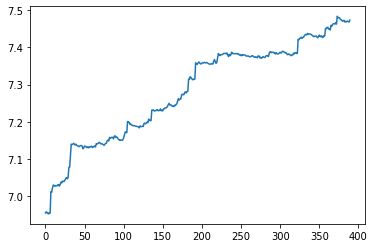

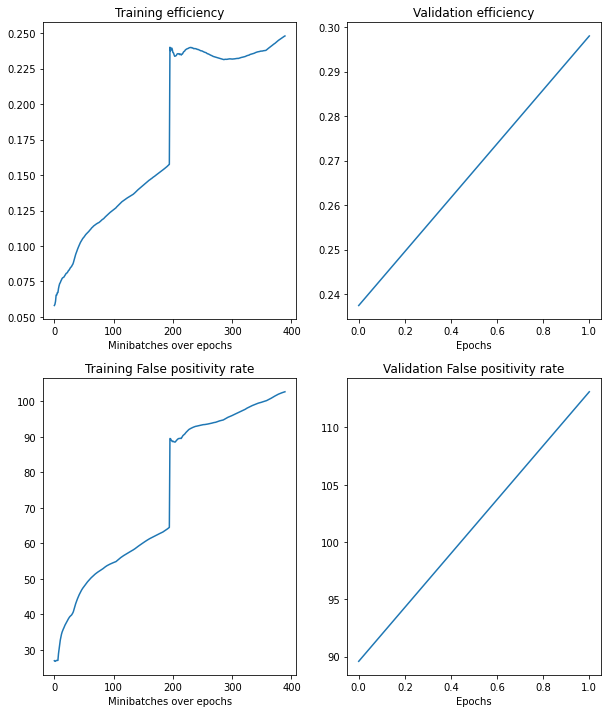

In [ ]:
plot_training_graphs(
    NUM_EPOCHS,
    cost_m,
    efficiency_train_m,
    efficiency_val_m,
    fp_rate_train_m,
    fp_rate_val_m)

Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000


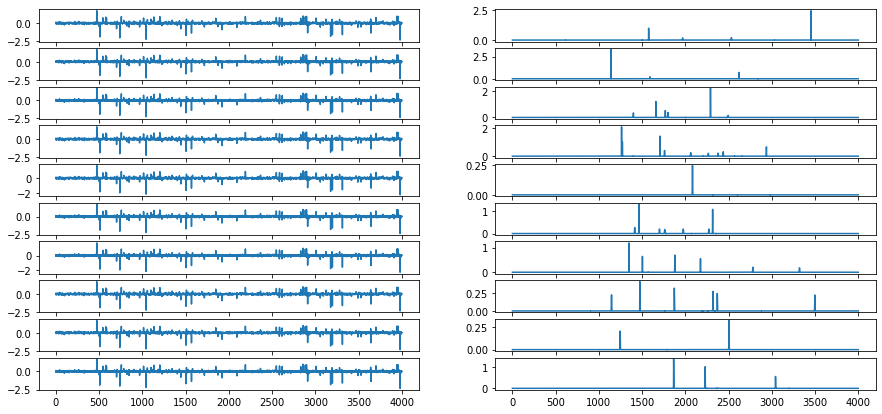

In [ ]:
plot_results(model_m,DEVICE, 6)

## Large dataset

In [ ]:
EMBEDDING_DIM = 512
HIDDEN_DIM = 128

loss_model = Loss(0.00001)
model_l = SimpleRNN4(num_input_features=16000,
            embedding_dim=EMBEDDING_DIM,
            hidden_dim1=HIDDEN_DIM,
            hidden_dim2=512,
            num_output_features=4000)
model_l.to(DEVICE)

SimpleRNN4(
  (enco1): Linear(in_features=16000, out_features=512, bias=True)
  (rnn): LSTM(512, 128)
  (deco1): Linear(in_features=128, out_features=512, bias=True)
  (deco2): Linear(in_features=512, out_features=4000, bias=True)
)

In [ ]:
print(get_params(model_l))

10639264


In [ ]:
NUM_EPOCHS = 1

In [ ]:
(cost_l,
 efficiency_train_l,
 efficiency_val_l,
 fp_rate_train_l,
 fp_rate_val_l) = train(model_l,
                        DEVICE=DEVICE,
                        loss_model=loss_model,
                        num_epochs=NUM_EPOCHS,
                        train_set_idx=train_set_idx_l,
                        val_set_idx=val_set_idx_db[:1],
                        learning_rate=0.000001,
                        seed=123,
                        batch_size=1000)

Start Time -  01/12/2022 14:42:35
Set index: 1, Set Id: 56
Epoch ID: 0   Set ID: 56  Batch ID: 1 | Loss: 6.95370
Epoch ID: 0   Set ID: 56  Batch ID: 2 | Loss: 6.95472
Epoch ID: 0   Set ID: 56  Batch ID: 3 | Loss: 6.95490
Epoch ID: 0   Set ID: 56  Batch ID: 4 | Loss: 6.95382
Epoch ID: 0   Set ID: 56  Batch ID: 5 | Loss: 6.95580
Set Time : 0.04509572188059489 minutes
Time till now : 0.045097068945566816 minutes
Set index: 2, Set Id: 28
Epoch ID: 0   Set ID: 28  Batch ID: 6 | Loss: 6.95525
Epoch ID: 0   Set ID: 28  Batch ID: 7 | Loss: 6.95292
Epoch ID: 0   Set ID: 28  Batch ID: 8 | Loss: 6.95469
Epoch ID: 0   Set ID: 28  Batch ID: 9 | Loss: 6.95522
Epoch ID: 0   Set ID: 28  Batch ID: 10 | Loss: 6.95455
Set Time : 0.059081315994262695 minutes
Time till now : 0.10419180393218994 minutes
Set index: 3, Set Id: 50
Epoch ID: 0   Set ID: 50  Batch ID: 11 | Loss: 6.95528
Epoch ID: 0   Set ID: 50  Batch ID: 12 | Loss: 6.95443
Epoch ID: 0   Set ID: 50  Batch ID: 13 | Loss: 6.95444
Epoch ID: 0   Set

In [ ]:
loss_val, eff_rate, fp_rate = validate(model_l, DEVICE, loss_model, val_set_idx_l)
print('Loss: %0.3f ' % loss_val, end="")
print('  Efficiency: %0.3f' % eff_rate, end="")
print('  False positive rate: %0.3f' % fp_rate)

Validating 
22
34
73
20
16
44
17
13
75
35
23
39
47
15
42
67
69
43
68
5
Loss: 6.954   Efficiency: 0.083  False positive rate: 29.514


1 295 295 1 295 1


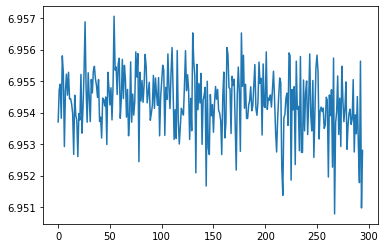

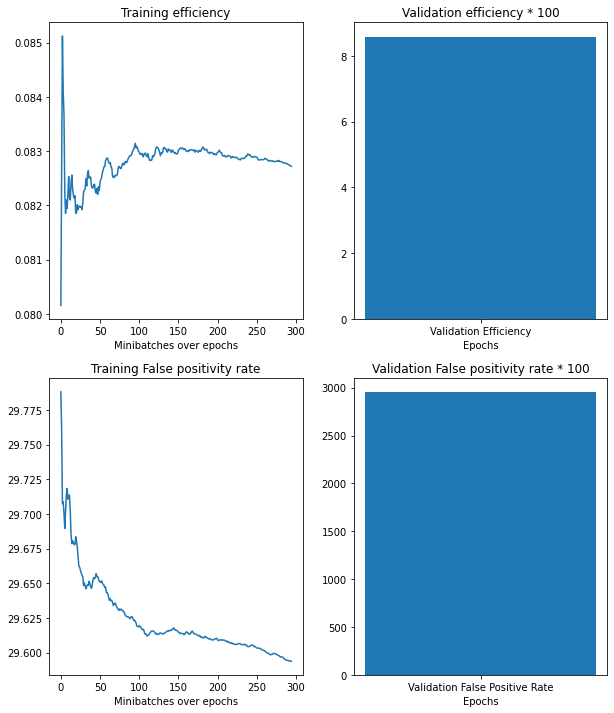

In [ ]:
plot_training_graphs(
    NUM_EPOCHS,
    cost_l,
    efficiency_train_l,
    efficiency_val_l,
    fp_rate_train_l,
    fp_rate_val_l)

Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000
Total correct 0 4000


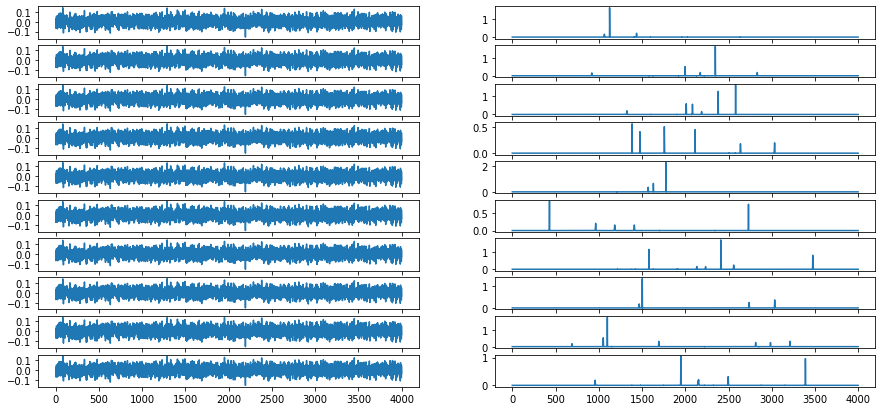

In [ ]:
plot_results(model_l,DEVICE, 6)